In [1]:
import glob
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from model import ConvTransformer, SimpleNN, BiLSTM
from losses import angle_constraint_loss, bone_length_consistency_loss
from dataset import *

In [2]:
filenames = glob.glob('../data/*.npz')
assert len(filenames) > 0, 'No data files found in ./data/'

filename = filenames[1]
data = np.load(filename)
print('Data containing:')
[print(f'Array {f} of shape {data[f].shape}') for f in data.files];

dt = np.diff(data['time'])
SAMPLE_RATE = 1.0 / np.mean(dt)
print('Sample rate:', SAMPLE_RATE)

Data containing:
Array time of shape (596,)
Array leftShoulderPosRel of shape (596, 3)
Array rightShoulderPosRel of shape (596, 3)
Array leftElbowPosRel of shape (596, 3)
Array rightElbowPosRel of shape (596, 3)
Array leftWristPosRel of shape (596, 3)
Array rightWristPosRel of shape (596, 3)
Array leftFingerPosRel of shape (596, 3)
Array rightFingerPosRel of shape (596, 3)
Array accelerationLeftLoc of shape (596, 3)
Array accelerationRightLoc of shape (596, 3)
Array gyroLeftLoc of shape (596, 3)
Array gyroRightLoc of shape (596, 3)
Sample rate: 60.0


In [3]:
subjects = np.unique([f.split('_')[-2] for f in filenames])
print(f'Found subjects: {subjects}')

np.random.seed(42) # For reproducibility
permutation = np.random.permutation(len(subjects))
train_subjects = subjects[permutation[:-1]]
test_subjects = subjects[permutation[-1:]]

print(f'Training on subjects: {train_subjects}')
print(f'Testing on subjects: {test_subjects}')

Found subjects: ['s1' 's10' 's2' 's3' 's4' 's5' 's6' 's7' 's8' 's9']
Training on subjects: ['s8' 's10' 's5' 's1' 's7' 's2' 's9' 's4' 's3']
Testing on subjects: ['s6']


In [4]:
def collate_fn(batch):
    longest_sample = max(batch, key=lambda x: len(x['time']))
    max_len = len(longest_sample['time']) # max_len
    padded_batch = []

    for sample in batch:
        padding_len = max_len - len(sample['time'])
        padded_sample = {}
        padded_sample['mocap'] = torch.cat([sample['mocap'],
                                            sample['mocap'][-1:].repeat(padding_len,1,1)]) # (max_len, 8, 3)
        acc = torch.cat([sample['imu'][:,[0,1]],
                         sample['imu'][-1:,[0,1]].repeat(padding_len,1,1)]) # (max_len, 2, 3)
        gyro = torch.cat([sample['imu'][:,[2,3]],
                          torch.zeros_like(sample['imu'][-1:,[2,3]]).repeat(padding_len,1,1)]) # (max_len, 2, 3)
        padded_sample['imu'] = torch.cat([acc, gyro], dim=1) # (max_len, 4, 3)
        padded_batch.append(padded_sample)

    return {'time': longest_sample['time'],
            'mocap': torch.stack([sample['mocap'] for sample in padded_batch]),
            'imu': torch.stack([sample['imu'] for sample in padded_batch])}

def compute_mpjpe(predictions, targets):
    """
    predictions, targets: (B, T, J, 3)
    Returns: scalar MPJPE (in meters)
    """
    error = torch.norm(predictions - targets, dim=-1)  # (B, T, J)
    return error.mean().item()

def compute_mpve(predictions, targets):
    """
    predictions, targets: (B, T, J, 3)
    Returns: scalar MPVE (in m/s)
    """
    pred_velocity = predictions[:, 1:, :, :] - predictions[:, :-1, :, :]  # (B, T-1, J, 3)
    target_velocity = targets[:, 1:, :, :] - targets[:, :-1, :, :]        # (B, T-1, J, 3)

    velocity_error = torch.norm(pred_velocity - target_velocity, dim=-1)  # (B, T-1, J)
    return velocity_error.mean().item()

# 1) Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Instantiate model with the same hyperparameters you used at train time
window_size = 60
batch_size = 32

### MODEL OPTION 1: Baseline LSTM -------------------------------

# model = SimpleNN(input_size=4*3, hidden_size=8*3, num_layers=2) 

### -------------------------------------------------------------


### MODEL OPTION 2: ConvTransformer -----------------------------

model = ConvTransformer(
    input_dim=12,
    transformer_dim=64,
    window_size=window_size,
    nhead=8,
    dim_feedforward=256,
    transformer_dropout=0.1,
    transformer_activation="gelu",
    num_encoder_layers=6,
    encode_position=True
)

###---------------------------------------------------------------


### MODEL OPTION 3: Bidirectional LSTM ---------------------------

# model = BiLSTM(input_size=12, hidden_size=12, num_layers=2)

###---------------------------------------------------------------
model.to(device)

# 3) Load pretrained weights
CHECKPOINT_PATH = "convtransformer_nopreprocess_withconstraints_batchsize32_winsize60_winshift15/checkpoint_epoch_24.pth"
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Loaded checkpoint from epoch {checkpoint['epoch']+1} with loss {checkpoint['loss']:.4f}")

Loaded checkpoint from epoch 25 with loss 0.0064


/home/patrick-do/Documents/Projects/CS690R_Project/cs690r/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


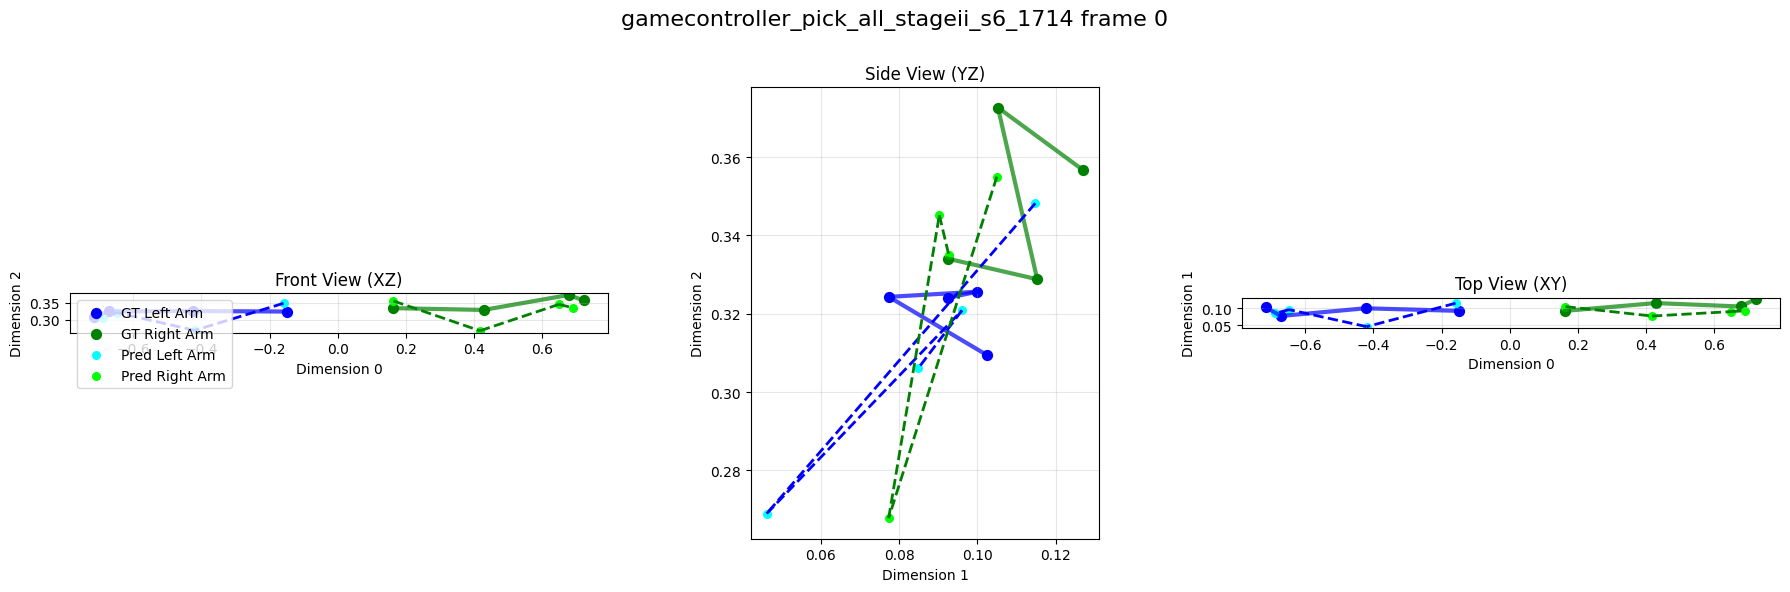

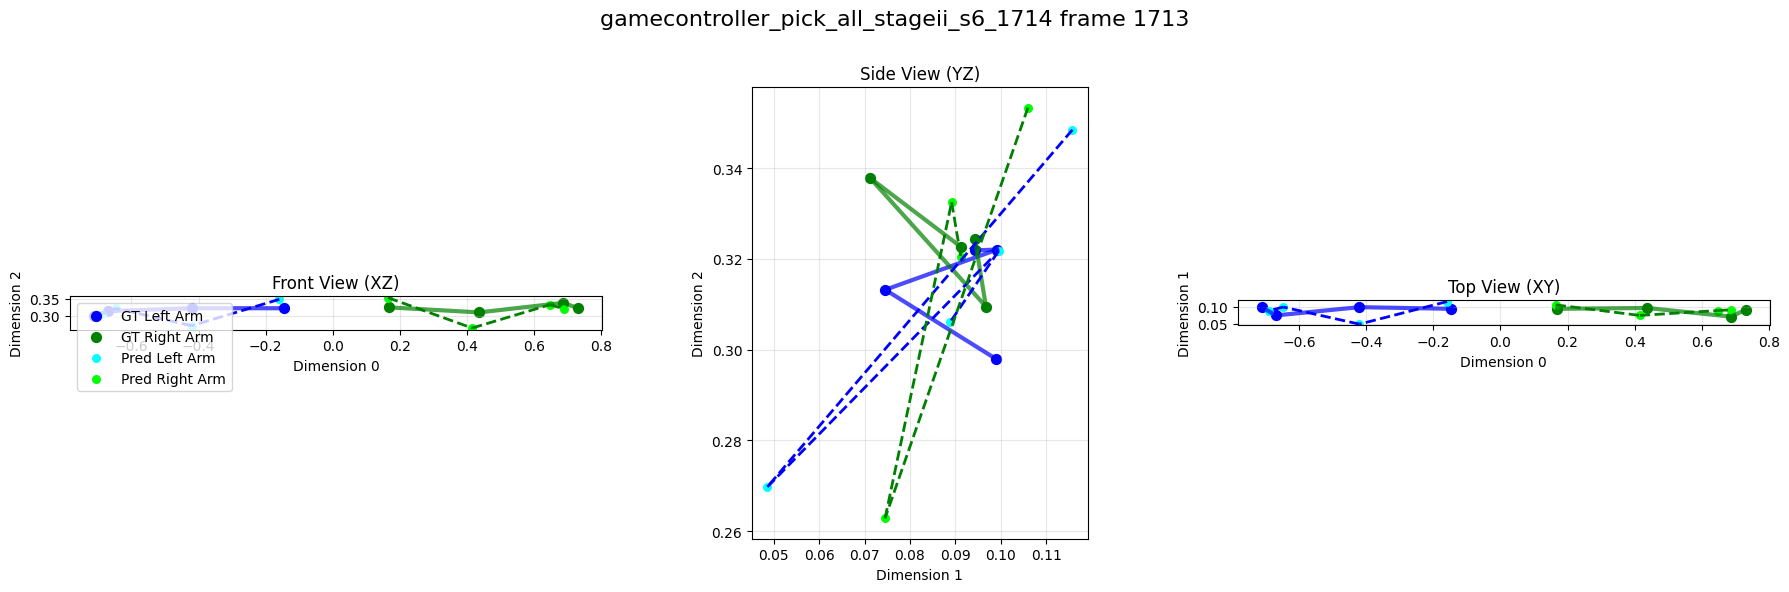

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1800x600', '-pix_fmt', 'rgba', '-framerate', '30', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'result_convTrans2/gamecontroller_pick_all_stageii_s6_1714.mp4']' returned non-zero exit status 255.

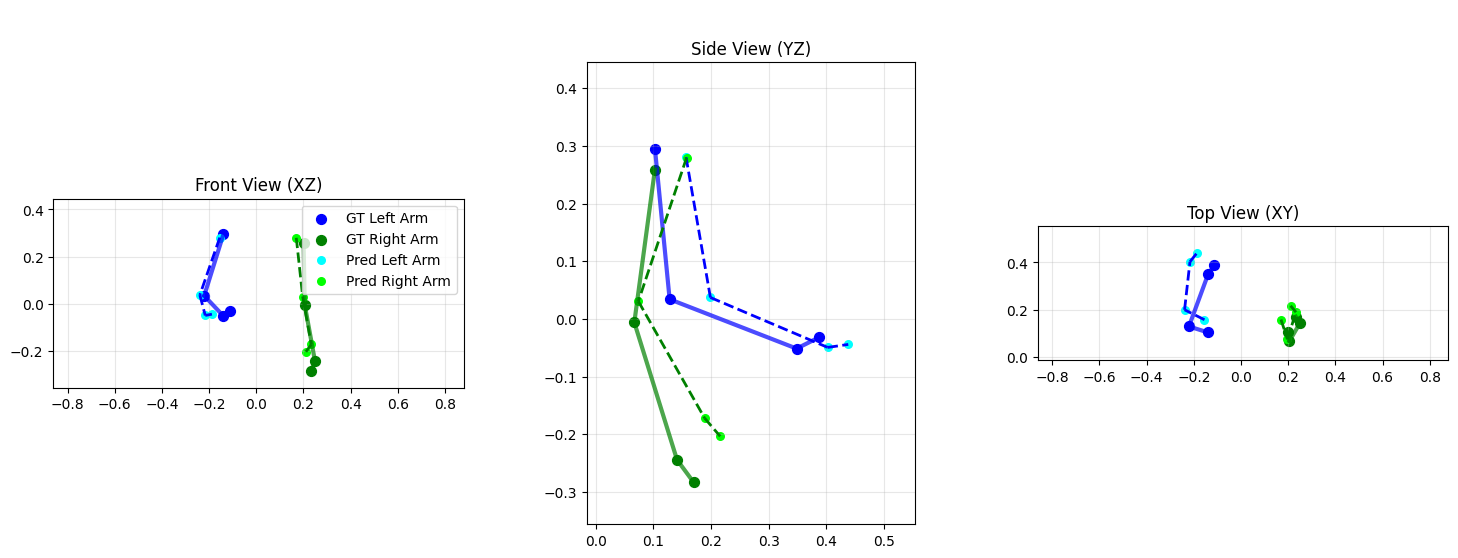

In [ ]:
from utils import *

##### PLEASE CHOOSE WINDOW SHIFT OF 1 ######
# Call the visualization function after training
vis_dataset = IMUDataset([f for f in filenames if any(s == f.split('_')[-2] for s in test_subjects)], 
                          filter=False, 
                          window_size=window_size, 
                          window_shift=1)

vis_result_path = 'result_convTrans' # Path of visualization results
os.makedirs(vis_result_path, exist_ok=True)

visualize_each_file(model, vis_dataset, device, fps=30, save_path=vis_result_path)